#### Jupyter notebook to compute shear across ERA5 ensemble for TC forcing data.

James Ruppert  
jruppert@ou.edu  
6/15/25

With support from ChatGPT

#### Main Settings

In [1]:
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
from read_wrf_functions import *
import xarray as xr
from tropycal import tracks

In [2]:
# Select case
storms = ['nepartak', 'maria', 'hector']
# storms = ['maria']

#### Directories and grib files
datdir = "/glade/campaign/univ/uokl0049/"
file_tag="mem*/grib/ERA*-pl*grib"

# Get grib file ensemble
grib_files = {}
grib_times = {}
for storm in storms:
    igrib_files = get_wrf_file_list(datdir+storm+"/", file_tag)
    grib_files[storm] = igrib_files

    # Get times
    ds = xr.open_mfdataset(igrib_files[0], engine="cfgrib", combine='by_coords')
    # ds = grib_file.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
    grib_times[storm] = ds.time.values.astype('datetime64[m]')
    ds.close()

nmemb = len(igrib_files)
nt_grib = len(grib_times[storms[0]])

In [3]:
# # Print some metadata
# ds_plevs = xr.open_mfdataset(grib_files[0], combine='by_coords', engine="cfgrib", filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

# for ds in [ds_plevs]:
#     for ivar in ds.data_vars:
#         print(ivar)
#         print(ds[ivar].attrs['standard_name'])
#         print(ds[ivar].attrs['long_name'])
#         print(ds[ivar].dims)
#         print(ds[ivar].units)
#         print(ds[ivar].shape)
#         print()

### Read and process data

#### Read in observed storm track

In [7]:
# Read in basin only if it hasn't been yet
for storm in storms:
    if 'tc_track' not in locals():
        tc_track = {}
        basin = {}
    if storm in tc_track.keys():
        continue
    match storm:
        case 'nepartak':
            basin_tag='west_pacific'
            storm_year = 2016
        case 'maria':
            basin_tag='north_atlantic'
            storm_year = 2017
        case 'hector':
            basin_tag='east_pacific'
            storm_year = 2018
        case _:
            raise ValueError(f"Unknown storm: {storm}")
    if basin_tag not in basin.keys():
            basin[basin_tag] = tracks.TrackDataset(source='ibtracs', basin=basin_tag)
    tropycal_storm = basin[basin_tag].get_storm((storm,storm_year))
    tc_track[storm] = {
        'vmax': tropycal_storm.vars['vmax'],
        'mslp': tropycal_storm.vars['mslp'],
        'lon': tropycal_storm.vars['lon'],
        'lat': tropycal_storm.vars['lat'],
        'time': np.array(tropycal_storm.vars['time'], dtype='datetime64[m]'),
        # 'lon': tropycal_storm.vars['wmo_lon'],
        # 'lat': tropycal_storm.vars['wmo_lat'],
        }

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (32.57 seconds)
--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (36.06 seconds)
--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (3.52 seconds)


In [8]:
# Interpolate observed TC track to GRIB data times

tc_track_gribtimes = {}
nt_interp = {}

for storm in storms:

    valid_times = []
    vmax = []
    pres = []
    ilon = []
    ilat = []
    for it in range(nt_grib):
        # Skip if the time is not in the TC track
        if grib_times[storm][it] < np.min(tc_track[storm]['time']) or grib_times[storm][it] > np.max(tc_track[storm]['time']):
            continue
        # print(f"Interpolating TC track for time {grib_times[it]}")
        valid_times.append(grib_times[storm][it])
        vmax.append(np.interp(grib_times[storm][it].astype(float), tc_track[storm]['time'].astype(float), tc_track[storm]['vmax']))
        pres.append(np.interp(grib_times[storm][it].astype(float), tc_track[storm]['time'].astype(float), tc_track[storm]['mslp']))
        ilon.append(np.interp(grib_times[storm][it].astype(float), tc_track[storm]['time'].astype(float), tc_track[storm]['lon']))
        ilat.append(np.interp(grib_times[storm][it].astype(float), tc_track[storm]['time'].astype(float), tc_track[storm]['lat']))

    # Convert lists to numpy arrays
    tc_track_gribtimes[storm] = {
        'time': np.array(valid_times, dtype='datetime64[m]'),
        'vmax': np.array(vmax),
        'mslp': np.array(pres),
        'lon': np.array(ilon),
        'lat': np.array(ilat),
    }

    nt_interp[storm] = len(tc_track_gribtimes[storm]['time'])

#### Run ERA5 processing for testing

In [ ]:
# # Get list of surface files
# file_tag="mem*/grib/ERA*-sl*grib"
# # Get grib file ensemble
# sfc_grib_files = get_wrf_file_list(datdir, file_tag)
# sfc_grib_files[0]

In [48]:
# Pick a storm, any storm
istorm_select = 2

# Parameters for shear calculation
plevs_shear=(850,200)
radius_min_km = 200 # Maximum distance from TC center to compute shear
radius_max_km = 800

# Compute great-circle distance from each grid point to center point
def compute_distance_grid(lat_grid, lon_grid, center_lat, center_lon):
    flat_lat = lat_grid.ravel()
    flat_lon = lon_grid.ravel()
    distances = np.array([
        distance((center_lat, center_lon), (la, lo)).km
        for la, lo in zip(flat_lat, flat_lon)
    ])
    return distances.reshape(lat_grid.shape)

# mean_shear_ens = []

# for imember, grib_file in enumerate(tqdm_notebook(grib_files[:2])):

ds = xr.open_mfdataset(grib_files[storms[istorm_select]][0], engine="cfgrib", combine='by_coords',
                       filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
# ds = xr.open_mfdataset(sfc_grib_files[0], combine='by_coords', engine="cfgrib",
#                            filter_by_keys={'typeOfLevel': 'surface'})
# ds = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# Regional subset to work with smaller dataset
buffer = 9
latmin, latmax, lonmin, lonmax = \
    np.min(tc_track_gribtimes[storms[istorm_select]]['lat'])-buffer, np.max(tc_track_gribtimes[storms[istorm_select]]['lat'])+buffer, \
    np.min(tc_track_gribtimes[storms[istorm_select]]['lon'])-buffer, np.max(tc_track_gribtimes[storms[istorm_select]]['lon'])+buffer

# Adjust to absolute longitude for consistency with ERA5
lonmin = ((lonmin - 180) % 360) + 180
lonmax = ((lonmax - 180) % 360) + 180

ds = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# Create 2D mesh of lat-lon points
lat = ds['latitude']
lon = ds['longitude']
lon2d, lat2d = np.meshgrid(lon, lat)

# itime=nt_interp[storms[istorm_select]]-1
itime=1

# Get shear
u850 = ds.u.sel(time=tc_track_gribtimes[storms[istorm_select]]['time'][itime], isobaricInhPa=plevs_shear[0])
v850 = ds.v.sel(time=tc_track_gribtimes[storms[istorm_select]]['time'][itime], isobaricInhPa=plevs_shear[0])
u200 = ds.u.sel(time=tc_track_gribtimes[storms[istorm_select]]['time'][itime], isobaricInhPa=plevs_shear[1])
v200 = ds.v.sel(time=tc_track_gribtimes[storms[istorm_select]]['time'][itime], isobaricInhPa=plevs_shear[1])
# ushear = u200 - u850
# vshear = v200 - v850
# shear = np.sqrt(ushear**2 + vshear**2)

shear_plot = u850

# # for itime in range(nt_interp):
# for itime in range(30,31):

    # Get the center point of the TC track at this time
lat_center = tc_track_gribtimes[storms[istorm_select]]['lat'][itime]
lon_center = tc_track_gribtimes[storms[istorm_select]]['lon'][itime]

    # Compute distance grid from center point
distance_grid = compute_distance_grid(lat2d, lon2d, lat_center, lon_center)
    # Mask the shear for current time step to annulus
shear_plot = shear_plot.where(
    ((distance_grid >= radius_min_km) & (distance_grid <= radius_max_km)))
    # ((distance_grid <= radius_max_km)))
u850_masked = u850.where(
    ((distance_grid <= radius_max_km)))
v850_masked = v850.where(
    ((distance_grid <= radius_max_km)))
u200_masked = u200.where(
    ((distance_grid <= radius_max_km)))
v200_masked = v200.where(
    ((distance_grid <= radius_max_km)))
u850_mean = u850_masked.mean(skipna=True)
v850_mean = v850_masked.mean(skipna=True)
u200_mean = u200_masked.mean(skipna=True)
v200_mean = v200_masked.mean(skipna=True)
ushear = u200_mean - u850_mean
vshear = v200_mean - v850_mean
shear = np.sqrt(ushear**2 + vshear**2)
print(shear)

<xarray.DataArray ()> Size: 4B
dask.array<sqrt, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B 0
    time        datetime64[ns] 8B 2018-07-31T15:00:00
    step        timedelta64[ns] 8B 00:00:00
    valid_time  datetime64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>


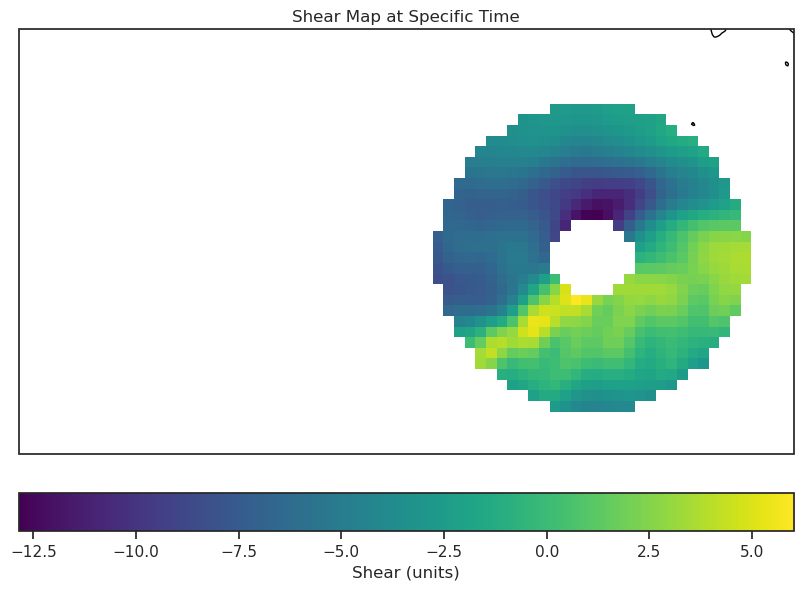

In [49]:
# Plot a map of shear at a specific time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Specific time index (if shear is time-dependent, select the appropriate slice)
# shear = shear[time_index, :, :]  # Uncomment if shear has a time dimension

# Create the map
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))

# Plot the shear data
plot_object = ax.pcolormesh(lon, lat, shear_plot,
                           transform=ccrs.PlateCarree(), cmap='viridis', shading='nearest')

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title('Shear Map at Specific Time')

# Add a colorbar
cbar = plt.colorbar(plot_object, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Shear (units)')

# Show the plot
plt.show()

In [40]:
lon

<xarray.DataArray 'longitude' (longitude: 65)> Size: 520B
array([219.5, 220. , 220.5, 221. , 221.5, 222. , 222.5, 223. , 223.5, 224. ,
       224.5, 225. , 225.5, 226. , 226.5, 227. , 227.5, 228. , 228.5, 229. ,
       229.5, 230. , 230.5, 231. , 231.5, 232. , 232.5, 233. , 233.5, 234. ,
       234.5, 235. , 235.5, 236. , 236.5, 237. , 237.5, 238. , 238.5, 239. ,
       239.5, 240. , 240.5, 241. , 241.5, 242. , 242.5, 243. , 243.5, 244. ,
       244.5, 245. , 245.5, 246. , 246.5, 247. , 247.5, 248. , 248.5, 249. ,
       249.5, 250. , 250.5, 251. , 251.5])
Coordinates:
    number     int64 8B ...
    step       timedelta64[ns] 8B ...
  * longitude  (longitude) float64 520B 219.5 220.0 220.5 ... 250.5 251.0 251.5
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude

#### Read in ERA5 shear

In [9]:
# Read in processed data
mean_shear = {}
for storm in storms:
    # Check which files to read
    file_merged = "era5ens_shear_"+storm+".nc"
    if not os.path.exists(file_merged):
        # Write combined netCDF file
        ds_all = xr.open_mfdataset("era5ens_shear_imemb_*"+storm+".nc")
        ds_all.to_netcdf(file_merged)
        ds_all.close()
    # Read merged file
    ds_all = xr.open_dataset(file_merged)
    mean_shear[storm] = np.transpose(ds_all.mean_shear.values)
    ds_all.close()

---
### Plotting routines

##### Plot functions

In [10]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}

rc('font', **font)

sns.set_theme(style="white", rc={'xtick.bottom': True, 'ytick.left': True, "axes.spines.right": False, "axes.spines.top": False})

#### Create plots

In [11]:
# Get all times up to first time when vmax >= 64 kts
vmax_thresh = 64.0
itimes_inc = {}
for storm in storms:
    # Find the first index where vmax >= vmax_thresh
    t1_avg = np.where(tc_track_gribtimes[storm]['vmax'] >= vmax_thresh)[0][0]-1
    itimes_inc[storm] = np.arange(0, t1_avg+1)
    # nt_inc = len(itimes_inc[storm])
    # print(f"{storm}: {nt_inc} times up to first vmax >= {vmax_thresh} kts")
    # print(tc_track_gribtimes['time'][itimes_inc])

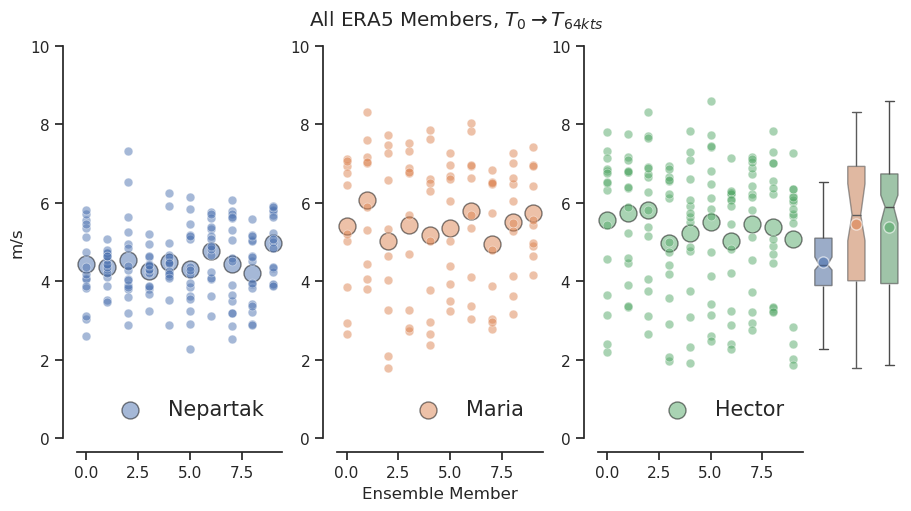

In [35]:
# Plot all ensemble members

fig, ax = plt.subplots(1,6, figsize=(9,5), layout="constrained", width_ratios=(1, 1, 1, 0.12, 0.12, 0.12))

# palette = sns.color_palette("colorblind")#, n_colors=ishear.shape[1])
palette = sns.color_palette()#, n_colors=ishear.shape[1])

for istorm, storm in enumerate(storms):

    ishear = mean_shear[storm][:,itimes_inc[storm]]
    # ishear = mean_shear[storm]

    x = np.repeat(np.arange(0,nmemb)[:,np.newaxis], ishear.shape[1], axis=1)

    icolor = palette[istorm]
    # palette = sns.color_palette("Spectral_r", n_colors=ishear.shape[1])
    # Repeat the list nmemb times
    # palette_nx = palette*nmemb

    # Main scatterplot
    sns.scatterplot(ax=ax[istorm], x=x.flatten(), y=ishear.flatten(), color=icolor, alpha=0.5, s=40, zorder=2)

    # Calculate ensemble means and overlay them
    mean_shear_avg = np.mean(ishear, axis=1)
    sns.scatterplot(ax=ax[istorm], x=np.arange(0,nmemb), y=mean_shear_avg, color=icolor,
                    s=150, label=storm.capitalize(), marker='o', alpha=0.5, zorder=1, edgecolor='black')

    sns.boxplot(ishear.flatten(), ax=ax[istorm+3],
                width=0.7, showmeans=True,
                color=icolor, showfliers=False,
                meanprops={"marker":"o", "markerfacecolor":icolor,
                            "markeredgecolor":"white", "markersize":"8", "alpha":0.6},
                notch=True, bootstrap=10000,
                boxprops=dict(alpha=0.6))

plt.suptitle(r'All ERA5 Members, $T_0\rightarrow T_{64kts}$')
ax[1].set_xlabel('Ensemble Member')
ax[0].set_ylabel('m/s')
for iax in range(6):
    ax[iax].set_ylim((0,10))
for iax in range(3):
    ax[iax].legend(loc='lower right', fontsize=15, frameon=False)
    sns.despine(offset=10,ax=ax[iax])

for iax in range(3,6):
    sns.despine(offset=10,ax=ax[iax], left=True, bottom=True)
    # Remove y-axis ticks from the second plot
    ax[iax].set_yticks([])
    ax[iax].set_xticks([])

plt.show()